# 1D NLSE Solver - Optimization

## 1 - Minimizing Width in Time Domain

In [103]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import os


# torch imports
import torch
import torch.nn.functional as F
import torch.optim as optim

# import module
from nlse import *

In [104]:
# define simulation parameters
Lz = 20.0               # Propagation distance in km
Nz = 100              # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 500              # Temporal window size (ps)
Nt = 1024               # Number of temporal points

# define the training parameters
N_train = 3000
lr = 1e-2

w_sd = 1.0
w_pen = 1e3

# define constraints
m = 6 # how many waves to consider / penalize
mask_percent = 0.8 # percentage of the time window taken up by mask / penalty

# define medium parameters
beta2 = -20           # Dispersion coefficient in ps^2/km
gamma = 20


# get frequencies for plotting
freqs = get_freqs(Nt, Lt) # get frequencies for plotting
# get time for plotting
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)

### Define Initial Guess and Trainable Parameters
Our initial guess is of form: , $$A(0, t) e^{i\vec{0}}$$, where$$A(0,t) = \sqrt{P_0} e^{ - t^2/2 T_0^2}$$ and $\vec{0}$ is just the complex vector of $0 + 0j$ and therefore also our inital guess for our trainable parameters is a vector of ones (the phase $\vec{\phi} = e^{i\vec{0}}$)

In [105]:
def gaussian_pulse(t, center, T0, P0):
    """Generate a Gaussian pulse using PyTorch."""
    return torch.sqrt(torch.tensor(P0)) * torch.exp(-((t - center) ** 2) / (2 * T0 ** 2))

# set Gaussian parameters
center = Lt / 2         # Center of the Gaussian pulse
T0 = 15.0             # Width of the Gaussian pulse on ps
P0 = 0.005                # sqrt of the peak power of the Gaussian pulse

# independent variable (we use torch for automatic differentiation)
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)

A = gaussian_pulse(t, center, T0, P0) # defining the invariant initial pulse shape
phase0 = torch.ones_like(A).type(torch.complex128) # defining the phase of the initial pulse

phase = torch.nn.Parameter(phase0.clone().detach().requires_grad_(True)) # making the phase a learnable parameter

# define function to get pulse given phase
def get_pulse(phase):
    # normalize phase to unit norm
    phase_norm = phase / torch.abs(phase) # becomes just list full of unit-phasors
    return A * phase_norm

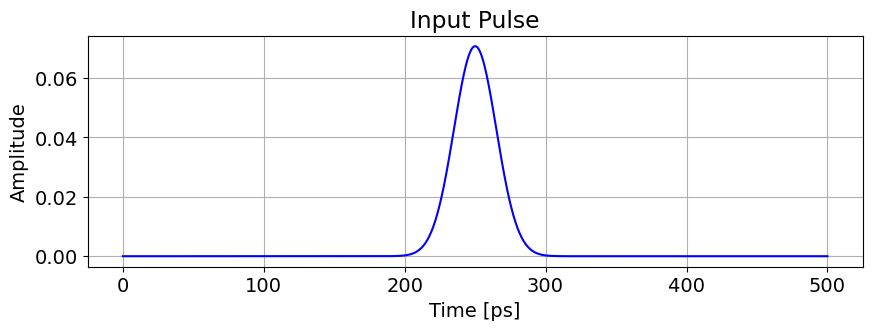

In [106]:
# plot initial guess
Ain = get_pulse(phase)
plt.figure(figsize=(10, 3))
plt.plot(t, torch.abs(Ain).detach().numpy(), color = 'blue') 
plt.xlabel('Time [ps]')
plt.ylabel('Amplitude')
plt.title('Input Pulse')
plt.grid()
plt.show()

### Define Useful Functions

We define a function to be as a proxy for the SD of the pulse (for a Gaussian Pulse this is $T_0$)

In [107]:
# define function to calculate SD of pulse (as if it were a distribution - unnormalized)
def get_sd(vals, distr):
    # normalize distr
    distr = distr / torch.sum(distr)
    mean = torch.sum(vals * distr)
    var = torch.sum((vals - mean)**2 * distr)
    return torch.sqrt(var)

# test
print("SD: ", get_sd(t, torch.abs(Ain)).item(), "T0: ", T0)
   

SD:  14.999997890499928 T0:  15.0


### Define Penalty
Anything outside of initial mask gets penalized

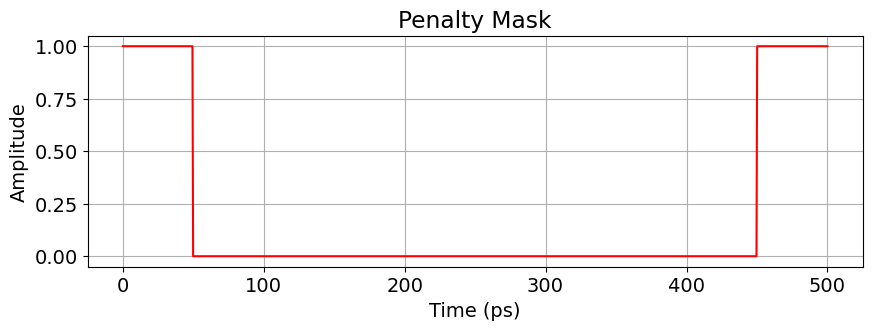

In [108]:
# define mask (so that pulse is periodic)
penalty = torch.zeros(Nt)
penalty[:int(Nt/2-Nt*mask_percent/2)] = 1
penalty[int(Nt/2+Nt*mask_percent/2):] = 1

# plot penalty
plt.figure(figsize=(10, 3))
plt.plot(t, penalty, color='r')
plt.xlabel('Time (ps)')
plt.ylabel('Amplitude')
plt.title('Penalty Mask')
plt.grid()
plt.show()

### Define Model and Loss Function

In [109]:
def forward(phase):
    Ain = get_pulse(phase)
    # Perform the split-step Fourier method
    A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)
    iters = np.linspace(0, Nz-1, m).astype(int)
    return A_evolution[:, iters]

def loss_function(Aev):
    # return the mean squared error
    # calculate standard deviation of the last pulse
    sd_pulse = get_sd(t, torch.abs(Aev[:,-1]))
    
    # pen_loss = 0
    # for i in range(m):
    #     pen_loss = F.mse_loss(torch.abs(Aev[:, i]*penalty)**2, torch.zeros(Nt), reduction='sum')   
        
    # print("SD Loss: ", sd_pulse.item(), "effective loss: ", w_sd * sd_pulse.item())
    # print("Penalty Loss: ", pen_loss.item(), "effective loss: ", w_pen * pen_loss.item())
    
    return w_sd * sd_pulse #+ w_pen * pen_loss

optimizer = optim.Adam([phase], lr=lr)

In [110]:
# # test loss
# Aev = forward(phase)  # full forward pass
# loss = loss_function(Aev)  # calculate the loss


### Train Model

In [111]:
losses = []

# store initial loss/sd
loss0 = loss_function(forward(phase)).item()

# Training loop
for iter in range(N_train):
    # clear gradients from previous step
    optimizer.zero_grad()  

    Aev = forward(phase)  # full forward pass
    
    loss = loss_function(Aev)  # calculate the loss

    # backpropagate the loss
    loss.backward()
    
    # update the parameters
    optimizer.step()

    # save and print the loss every 100 iteration
    if iter % 10 == 0:
        losses.append(loss.item())
        if iter % 50 == 0:
            print(f"Iteration {iter}, Loss Difference: {loss0 - loss.item()}")

Iteration 0, Loss Difference: 0.0
Iteration 50, Loss Difference: 0.5724372863769531
Iteration 100, Loss Difference: 1.0868339538574219
Iteration 150, Loss Difference: 1.5224723815917969
Iteration 200, Loss Difference: 1.903564453125
Iteration 250, Loss Difference: 2.2888221740722656
Iteration 300, Loss Difference: 2.5990028381347656
Iteration 350, Loss Difference: 2.9473724365234375
Iteration 400, Loss Difference: 3.1880416870117188
Iteration 450, Loss Difference: 3.4222888946533203
Iteration 500, Loss Difference: 3.435483932495117
Iteration 550, Loss Difference: 3.4902896881103516
Iteration 600, Loss Difference: 3.6667861938476562
Iteration 650, Loss Difference: 3.8256702423095703
Iteration 700, Loss Difference: 3.8559036254882812
Iteration 750, Loss Difference: 3.8278369903564453
Iteration 800, Loss Difference: 3.903654098510742
Iteration 850, Loss Difference: 3.8735179901123047
Iteration 900, Loss Difference: 3.9298362731933594
Iteration 950, Loss Difference: 3.96990966796875
Iterat

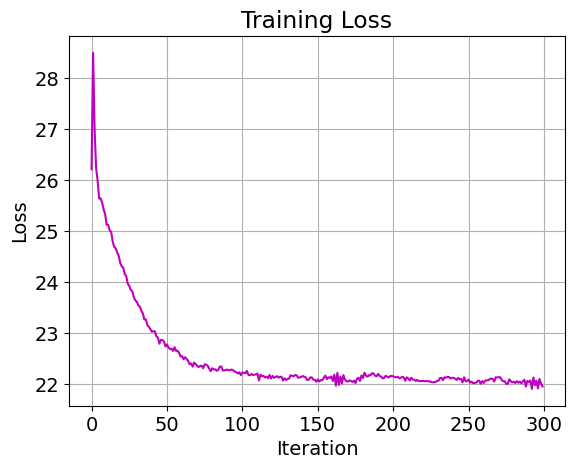

In [112]:
# plot the loss
plt.plot(losses, color='m')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

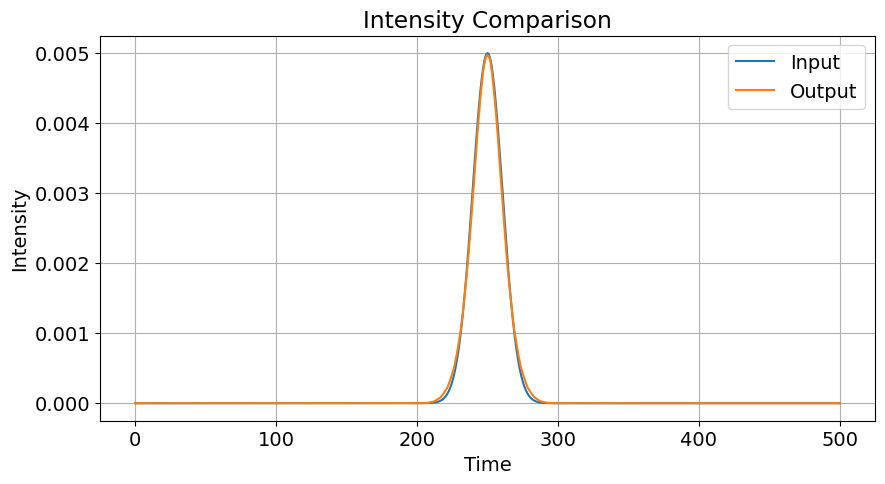

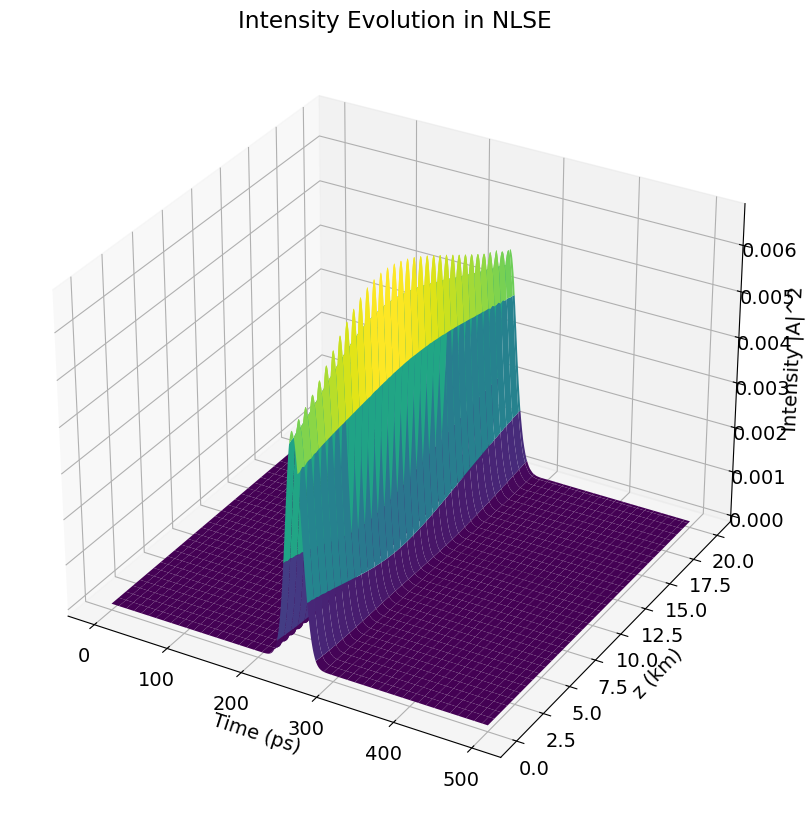

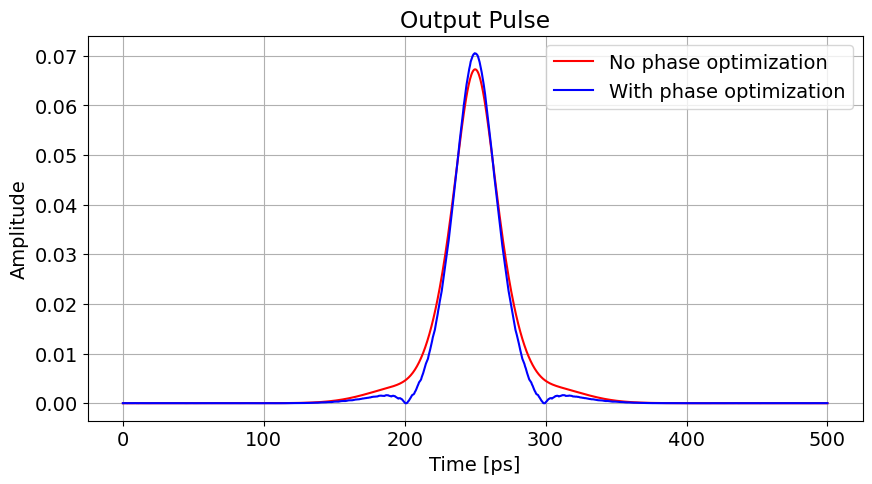

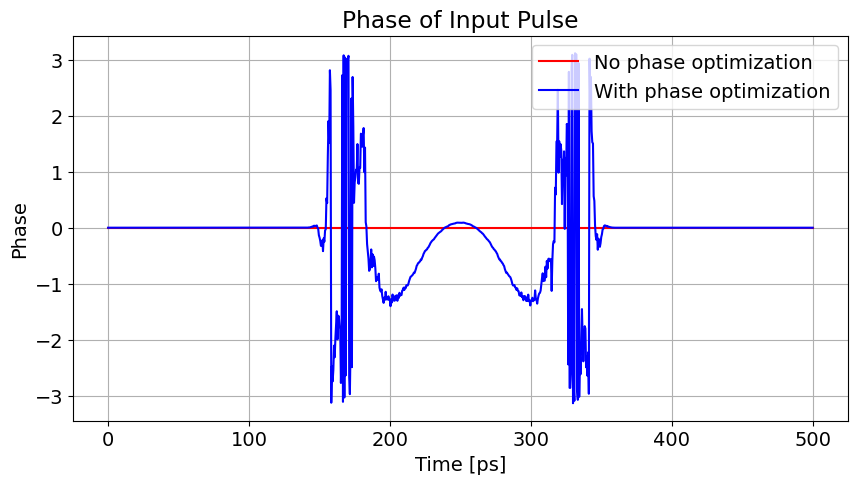

In [113]:
Ain = get_pulse(phase)
Aout = Aev[:, -1]
A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)

# make plots
plot_intensity_comparison(Ain, Aout, t)
plot_intensity_evolution(A_evolution, t, Lz, Nz)

Ain0 = A
Ain0_evolution = split_step_fourier(Ain0, dz, Nz, beta2, gamma, Lt)
A0out = Ain0_evolution[:, -1]

# plot output with zero-phased input A0 and optimized input Ain
plt.figure(figsize=(10, 5))
plt.plot(t, torch.abs(A0out).detach().numpy(), color='r', label='No phase optimization')
plt.plot(t, torch.abs(Aout).detach().numpy(), color='b', label='With phase optimization')
plt.xlabel('Time [ps]')
plt.ylabel('Amplitude')
plt.title('Output Pulse')
plt.legend()
plt.grid()
plt.show()

# plot phases of each input pulse
plt.figure(figsize=(10, 5))
plt.plot(t, torch.angle(Ain0).detach().numpy(), color='r', label='No phase optimization')
plt.plot(t, torch.angle(Ain).detach().numpy(), color='b', label='With phase optimization')
plt.xlabel('Time [ps]')
plt.ylabel('Phase')
plt.title('Phase of Input Pulse')
plt.legend()
plt.grid()
plt.show()



## 2 - Minimizing Width in Frequency Domain

In [114]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import os


# torch imports
import torch
import torch.nn.functional as F
import torch.optim as optim

# import module
from nlse import *

In [115]:
# define simulation parameters
Lz = 20.0               # Propagation distance in km
Nz = 100              # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 500              # Temporal window size (ps)
Nt = 1024               # Number of temporal points

# define the training parameters
N_train = 3000
lr = 1e-5

w_sd = 1
w_pen = 1e20

# define constraints
m = 6 # how many waves to consider / penalize
mask_percent = 0.8 # percentage of the time window taken up by mask / penalty

# define medium parameters
beta2 = -20           # Dispersion coefficient in ps^2/km
gamma = 20


# get frequencies for plotting
freqs = get_freqs(Nt, Lt) # get frequencies for plotting
# get time for plotting
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)

### Define Initial Guess and Trainable Parameters
Our initial guess is of form: , $$A(0, t) e^{i\vec{0}}$$, where$$A(0,t) = \sqrt{P_0} e^{ - t^2/2 T_0^2}$$ and $\vec{0}$ is just the complex vector of $0 + 0j$ and therefore also our inital guess for our trainable parameters is a vector of ones (the phase $\vec{\phi} = e^{i\vec{0}}$)

In [116]:
def gaussian_pulse(t, center, T0, P0):
    """Generate a Gaussian pulse using PyTorch."""
    return torch.sqrt(torch.tensor(P0)) * torch.exp(-((t - center) ** 2) / (2 * T0 ** 2))

# set Gaussian parameters
center = Lt / 2         # Center of the Gaussian pulse
T0 = 10.0             # Width of the Gaussian pulse on ps
P0 = 0.005                # sqrt of the peak power of the Gaussian pulse

# independent variable (we use torch for automatic differentiation)
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)

A = gaussian_pulse(t, center, T0, P0) # defining the invariant initial pulse shape
phase0 = torch.ones_like(A).type(torch.complex128) # defining the phase of the initial pulse

phase = torch.nn.Parameter(phase0.clone().detach().requires_grad_(True)) # making the phase a learnable parameter

# define function to get pulse given phase
def get_pulse(phase):
    # normalize phase to unit norm
    phase_norm = phase / torch.abs(phase) # becomes just list full of unit-phasors
    return A * phase_norm

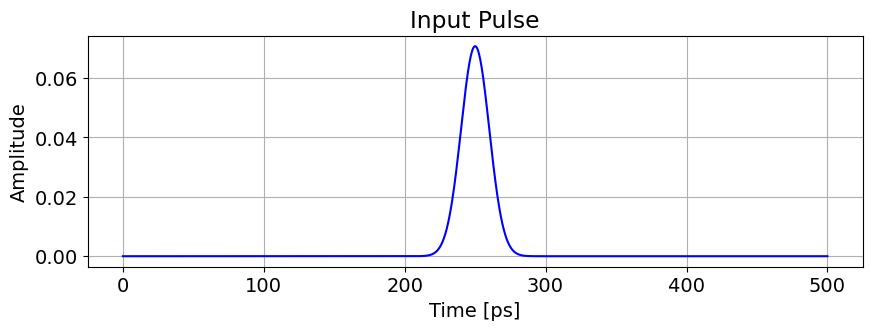

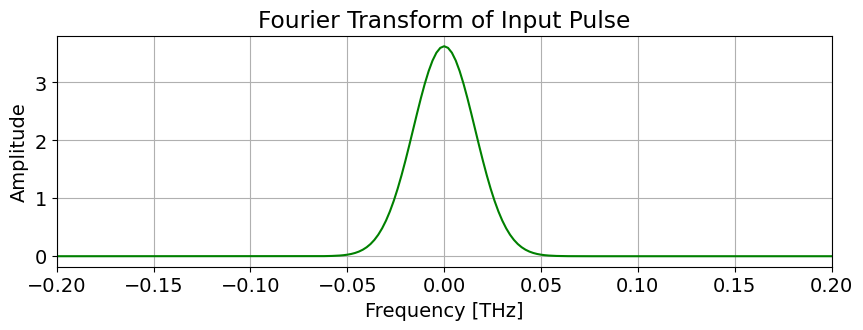

In [117]:
# plot initial guess
Ain = get_pulse(phase)
plt.figure(figsize=(10, 3))
plt.plot(t, torch.abs(Ain).detach().numpy(), color = 'blue') 
plt.xlabel('Time [ps]')
plt.ylabel('Amplitude')
plt.title('Input Pulse')
plt.grid()
plt.show()

# plot fourier transform of initial guess
plt.figure(figsize=(10, 3))
plt.plot(freqs, torch.abs(fft(Ain)).detach().numpy(), color = 'green')
# limit x axis
plt.xlim(-0.2, 0.2)
plt.xlabel('Frequency [THz]')
plt.ylabel('Amplitude')
plt.title('Fourier Transform of Input Pulse')
plt.grid()
plt.show()



### Define Useful Functions

We define a function to be as a proxy for the SD of the pulse (for a Gaussian Pulse this is $T_0$)

In [118]:
# define function to calculate SD of pulse (as if it were a distribution - unnormalized)
def get_sd(vals, distr):
    # normalize distr
    distr = distr / torch.sum(distr)
    mean = torch.sum(vals * distr)
    var = torch.sum((vals - mean)**2 * distr)
    return torch.sqrt(var)

# test
print("SD: ", get_sd(freqs, torch.abs(fft(Ain))).item())

SD:  0.015957999483744986


### Define Penalty
Anything outside of initial mask gets penalized

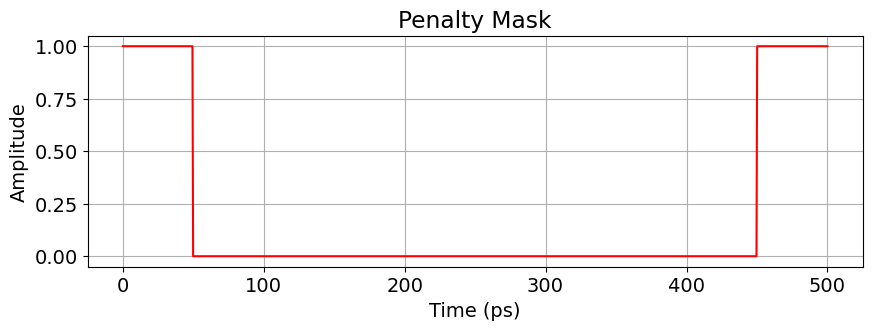

In [119]:
# define mask (so that pulse is periodic)
penalty = torch.zeros(Nt)
penalty[:int(Nt/2-Nt*mask_percent/2)] = 1
penalty[int(Nt/2+Nt*mask_percent/2):] = 1

# plot penalty
plt.figure(figsize=(10, 3))
plt.plot(t, penalty, color='r')
plt.xlabel('Time (ps)')
plt.ylabel('Amplitude')
plt.title('Penalty Mask')
plt.grid()
plt.show()

### Define Model and Loss Function

In [120]:
def forward(phase):
    Ain = get_pulse(phase)
    # Perform the split-step Fourier method
    A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)
    iters = np.linspace(0, Nz-1, m).astype(int)
    return A_evolution[:, iters]

def loss_function(Aev):
    # get absolute value of FFT of last pulse
    fft_last = torch.abs(fft(Aev[:,-1]))    
    sd_pulse = get_sd(freqs, fft_last)
    
    # pen_loss = 0
    # for i in range(m):
    #     pen_loss = F.mse_loss(torch.abs(Aev[:, i]*penalty)**2, torch.zeros(Nt), reduction='sum')   
        
    # print("SD Loss: ", sd_pulse.item(), "effective loss: ", w_sd * sd_pulse.item())
    # print("Penalty Loss: ", pen_loss.item(), "effective loss: ", w_pen * pen_loss.item())
    
    return w_sd * sd_pulse #+ w_pen * pen_loss

optimizer = optim.Adam([phase], lr=lr)

In [121]:
# test loss
Aev = forward(phase)  # full forward pass
loss = loss_function(Aev)  # calculate the loss


### Train Model

In [122]:
losses = []


loss0 = loss_function(forward(phase)).item()

# Training loop
for iter in range(N_train):
    # clear gradients from previous step
    optimizer.zero_grad()  

    Aev = forward(phase)  # full forward pass
    
    loss = loss_function(Aev)  # calculate the loss

    # backpropagate the loss
    loss.backward()
    
    # update the parameters
    optimizer.step()

    # save and print the loss every 100 iteration
    if iter % 10 == 0:
        losses.append(loss.item())
        if iter % 50 == 0:
            print(f"Iteration {iter}, Loss Difference: {loss0 - loss.item()}")

Iteration 0, Loss Difference: 0.0
Iteration 50, Loss Difference: -3.745686262845993e-05
Iteration 100, Loss Difference: -4.386063665151596e-05
Iteration 150, Loss Difference: -4.3004751205444336e-05
Iteration 200, Loss Difference: -4.3808482587337494e-05
Iteration 250, Loss Difference: -4.74490225315094e-05
Iteration 300, Loss Difference: -3.918725997209549e-05
Iteration 350, Loss Difference: -3.8106925785541534e-05
Iteration 400, Loss Difference: -4.147551953792572e-05
Iteration 450, Loss Difference: -4.324037581682205e-05
Iteration 500, Loss Difference: -3.712717443704605e-05
Iteration 550, Loss Difference: -4.4201500713825226e-05
Iteration 600, Loss Difference: -4.243571311235428e-05
Iteration 650, Loss Difference: -4.3412670493125916e-05
Iteration 700, Loss Difference: -4.651583731174469e-05
Iteration 750, Loss Difference: -4.575122147798538e-05
Iteration 800, Loss Difference: -4.512816667556763e-05
Iteration 850, Loss Difference: -4.8881396651268005e-05
Iteration 900, Loss Differe

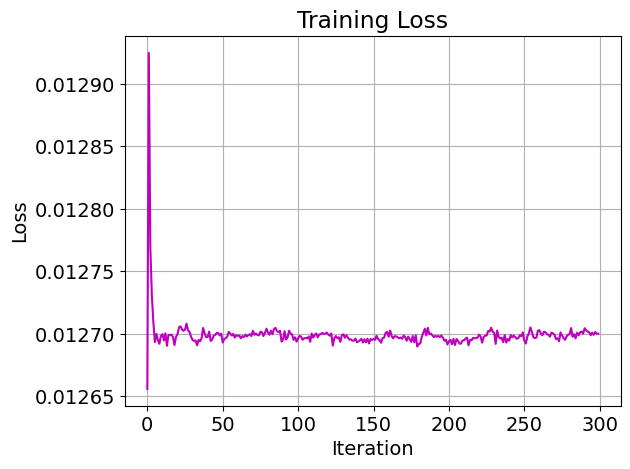

In [123]:
# plot the loss
plt.plot(losses, color='m')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

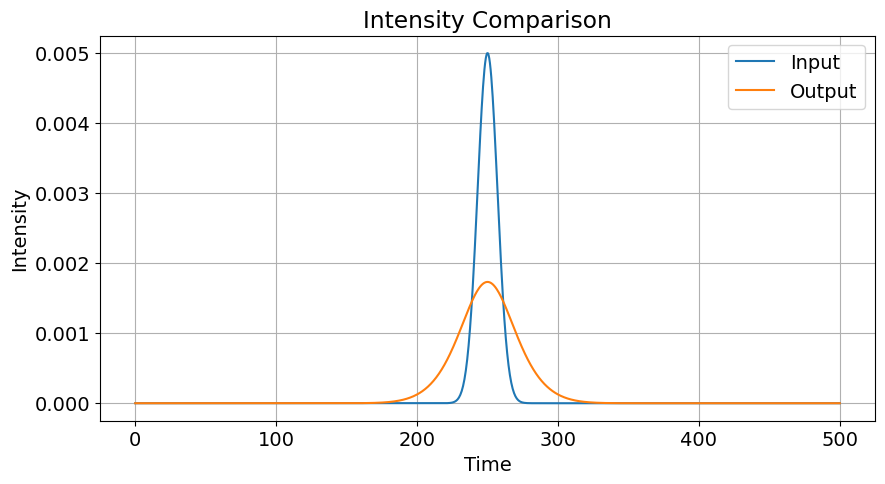

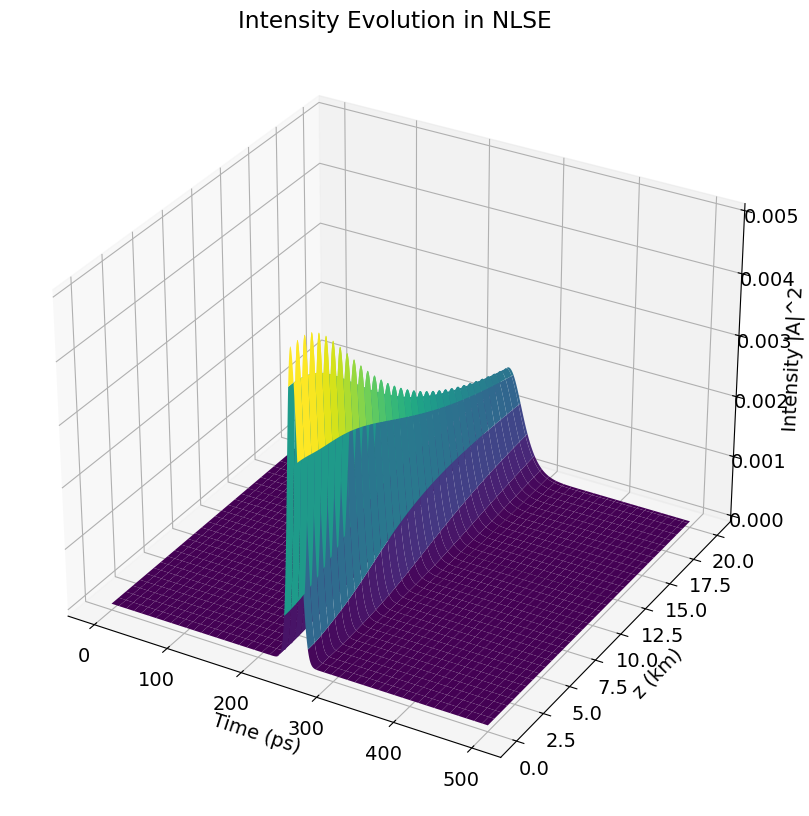

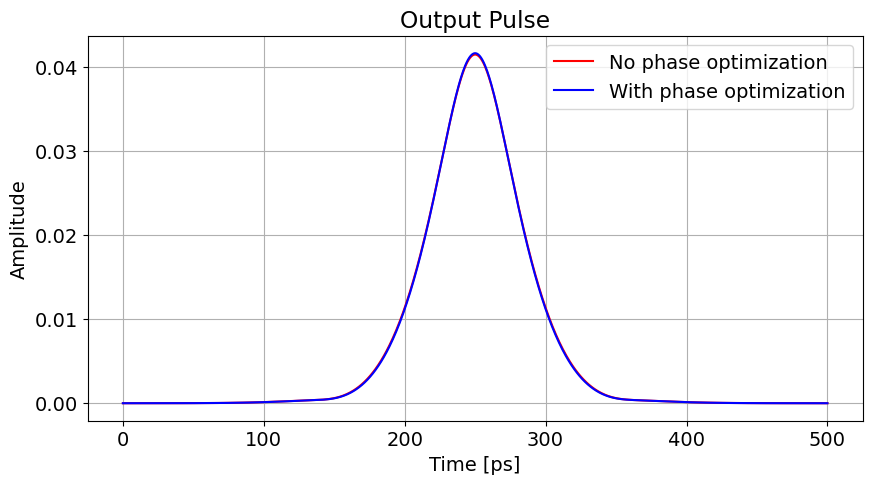

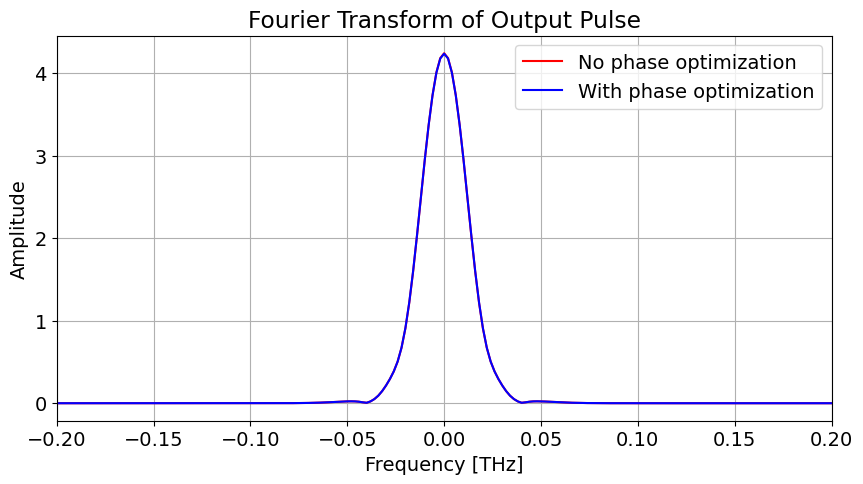

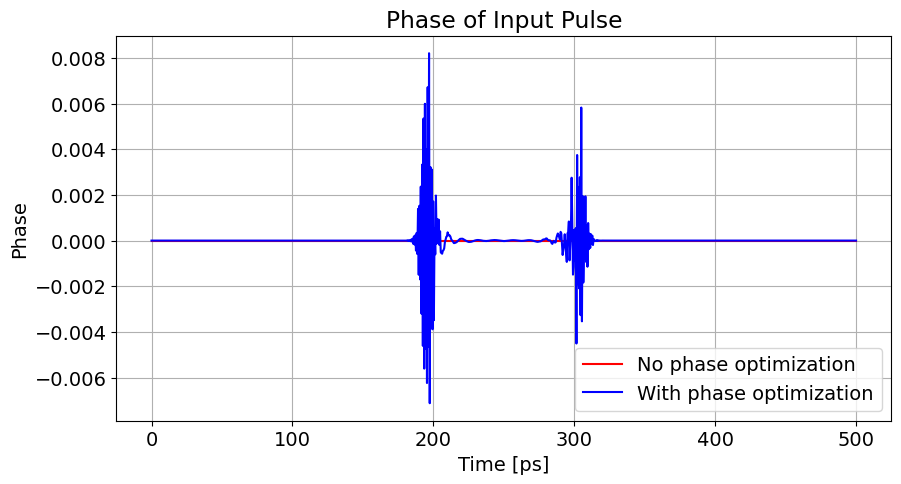

Max Frequency:  0.0
Initial Loss:  0.012737304903566837 Final Loss:  0.012695526704192162


In [124]:
Ain = get_pulse(phase)
Aout = Aev[:, -1]
A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)

# make plots
plot_intensity_comparison(Ain, Aout, t)
plot_intensity_evolution(A_evolution, t, Lz, Nz)

Ain0 = A
Ain0_evolution = split_step_fourier(Ain0, dz, Nz, beta2, gamma, Lt)
A0out = Ain0_evolution[:, -1]

# plot output with zero-phased input A0 and optimized input Ain
plt.figure(figsize=(10, 5))
plt.plot(t, torch.abs(A0out).detach().numpy(), color='r', label='No phase optimization')
plt.plot(t, torch.abs(Aout).detach().numpy(), color='b', label='With phase optimization')
plt.xlabel('Time [ps]')
plt.ylabel('Amplitude')
plt.title('Output Pulse')
plt.legend()
plt.grid()
plt.show()

# plot output with zero-phased input A0 and optimized input Ain FFTs
plt.figure(figsize=(10, 5))
plt.plot(freqs, torch.abs(fft(A0out)).detach().numpy(), color='r', label='No phase optimization')
plt.plot(freqs, torch.abs(fft(Aout)).detach().numpy(), color='b', label='With phase optimization')
plt.xlim(-0.2, 0.2)
plt.xlabel('Frequency [THz]')
plt.ylabel('Amplitude')
plt.title('Fourier Transform of Output Pulse')
plt.legend()
plt.grid()
plt.show()

# plot phases of each input pulse
plt.figure(figsize=(10, 5))
plt.plot(t, torch.angle(Ain0).detach().numpy(), color='r', label='No phase optimization')
plt.plot(t, torch.angle(Ain).detach().numpy(), color='b', label='With phase optimization')
plt.xlabel('Time [ps]')
plt.ylabel('Phase')
plt.title('Phase of Input Pulse')
plt.legend()
plt.grid()
plt.show()

# find max frequency of the output pulse
max_freq = freqs[torch.argmax(torch.abs(fft(Aout)))]

print("Max Frequency: ", max_freq.item())

# compare losses between A0 and Ain
A0_loss = loss_function(Ain0_evolution)
A_loss = loss_function(A_evolution)

print("Initial Loss: ", A0_loss.item(), "Final Loss: ", A_loss.item())

## 2.1 - Maximizing Width in Frequency Domain
We want all the frequency components to have roughly the "same" magnitude. One way to say this is we want their distribution to have a small SD (i.e. the actual values of each frequency component). 

In [125]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import os


# torch imports
import torch
import torch.nn.functional as F
import torch.optim as optim

# import module
from nlse import *

In [126]:
# define simulation parameters
Lz = 20.0               # Propagation distance in km
Nz = 100              # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 500              # Temporal window size (ps)
Nt = 1024               # Number of temporal points

# define the training parameters
N_train = 3000
lr = 1e-3

w_sd = 1
w_pen = 1e20

# define constraints
m = 6 # how many waves to consider / penalize
mask_percent = 0.8 # percentage of the time window taken up by mask / penalty

# define medium parameters
beta2 = -20           # Dispersion coefficient in ps^2/km
gamma = 20


# get frequencies for plotting
freqs = get_freqs(Nt, Lt) # get frequencies for plotting
# get time for plotting
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)

### Define Initial Guess and Trainable Parameters
Our initial guess is of form: , $$A(0, t) e^{i\vec{0}}$$, where$$A(0,t) = \sqrt{P_0} e^{ - t^2/2 T_0^2}$$ and $\vec{0}$ is just the complex vector of $0 + 0j$ and therefore also our inital guess for our trainable parameters is a vector of ones (the phase $\vec{\phi} = e^{i\vec{0}}$)

In [127]:
def gaussian_pulse(t, center, T0, P0):
    """Generate a Gaussian pulse using PyTorch."""
    return torch.sqrt(torch.tensor(P0)) * torch.exp(-((t - center) ** 2) / (2 * T0 ** 2))

# set Gaussian parameters
center = Lt / 2         # Center of the Gaussian pulse
T0 = 10.0             # Width of the Gaussian pulse on ps
P0 = 0.005                # sqrt of the peak power of the Gaussian pulse

# independent variable (we use torch for automatic differentiation)
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)

A = gaussian_pulse(t, center, T0, P0) # defining the invariant initial pulse shape
phase0 = torch.ones_like(A).type(torch.complex128) # defining the phase of the initial pulse

phase = torch.nn.Parameter(phase0.clone().detach().requires_grad_(True)) # making the phase a learnable parameter

# define function to get pulse given phase
def get_pulse(phase):
    # normalize phase to unit norm
    phase_norm = phase / torch.abs(phase) # becomes just list full of unit-phasors
    return A * phase_norm

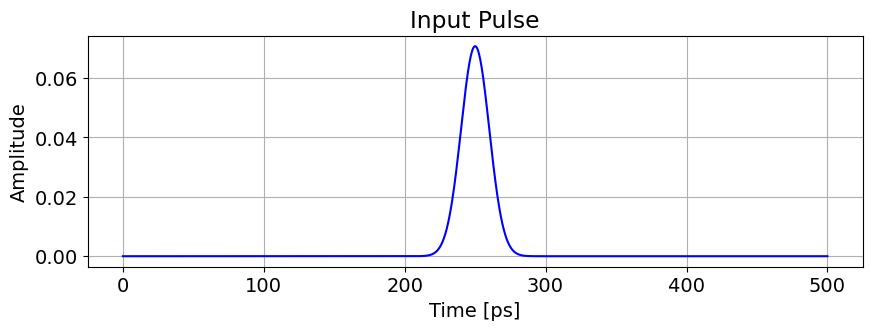

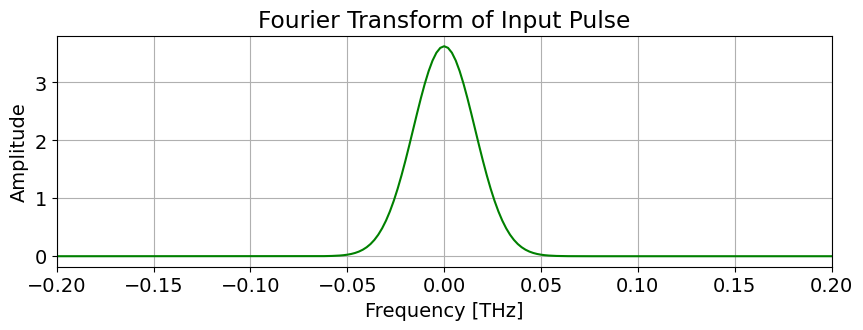

In [128]:
# plot initial guess
Ain = get_pulse(phase)
plt.figure(figsize=(10, 3))
plt.plot(t, torch.abs(Ain).detach().numpy(), color = 'blue') 
plt.xlabel('Time [ps]')
plt.ylabel('Amplitude')
plt.title('Input Pulse')
plt.grid()
plt.show()

# plot fourier transform of initial guess
plt.figure(figsize=(10, 3))
plt.plot(freqs, torch.abs(fft(Ain)).detach().numpy(), color = 'green')
# limit x axis
plt.xlim(-0.2, 0.2)
plt.xlabel('Frequency [THz]')
plt.ylabel('Amplitude')
plt.title('Fourier Transform of Input Pulse')
plt.grid()
plt.show()



### Define Penalty
Anything outside of initial mask gets penalized

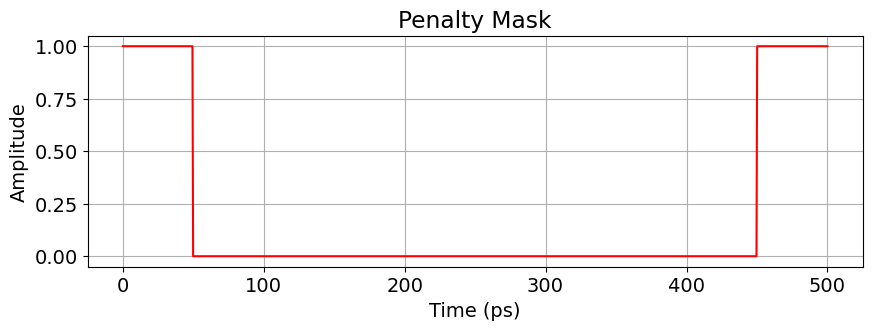

In [129]:
# define mask (so that pulse is periodic)
penalty = torch.zeros(Nt)
penalty[:int(Nt/2-Nt*mask_percent/2)] = 1
penalty[int(Nt/2+Nt*mask_percent/2):] = 1

# plot penalty
plt.figure(figsize=(10, 3))
plt.plot(t, penalty, color='r')
plt.xlabel('Time (ps)')
plt.ylabel('Amplitude')
plt.title('Penalty Mask')
plt.grid()
plt.show()

### Define Model and Loss Function

In [130]:
def forward(phase):
    Ain = get_pulse(phase)
    # Perform the split-step Fourier method
    A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)
    iters = np.linspace(0, Nz-1, m).astype(int)
    return A_evolution[:, iters]

def loss_function(Aev):
    # get absolute value of FFT of last pulse
    fft_last = torch.abs(fft(Aev[:,-1]))    
    # get standard deviation with pytorch
    sd_pulse = torch.std(fft_last)
    
    pen_loss = 0
    for i in range(m):
        pen_loss = F.mse_loss(torch.abs(Aev[:, i]*penalty)**2, torch.zeros(Nt), reduction='sum')   
        
    # print("SD Loss: ", sd_pulse.item(), "effective loss: ", w_sd * sd_pulse.item())
    # print("Penalty Loss: ", pen_loss.item(), "effective loss: ", w_pen * pen_loss.item())
    
    return w_sd * sd_pulse #+ w_pen * pen_loss

optimizer = optim.Adam([phase], lr=lr)

In [131]:
# test loss
Aev = forward(phase)  # full forward pass
loss = loss_function(Aev)  # calculate the loss


SD Loss:  0.42162957787513733 effective loss:  0.42162957787513733
Penalty Loss:  1.5938834655828893e-19 effective loss:  15.938834655828893


### Train Model

In [132]:
losses = []


loss0 = loss_function(forward(phase))
print("Initial Loss: ", loss.item())

# Training loop
for iter in range(N_train):
    # clear gradients from previous step
    optimizer.zero_grad()  

    Aev = forward(phase)  # full forward pass
    
    loss = loss_function(Aev)  # calculate the loss

    # backpropagate the loss
    loss.backward()
    
    # update the parameters
    optimizer.step()

    # save and print the loss every 100 iteration
    if iter % 10 == 0:
        losses.append(loss.item())
        if iter % 50 == 0:
            print(f"Iteration {iter}, Loss Difference: {loss0 - loss.item()}")

SD Loss:  0.42162957787513733 effective loss:  0.42162957787513733
Penalty Loss:  1.5938834655828893e-19 effective loss:  15.938834655828893
Initial Loss:  0.42162957787513733
SD Loss:  0.42162957787513733 effective loss:  0.42162957787513733
Penalty Loss:  1.5938834655828893e-19 effective loss:  15.938834655828893
Iteration 0, Loss Difference: 0.0
SD Loss:  0.4215870201587677 effective loss:  0.4215870201587677
Penalty Loss:  1.7054938909793883e-17 effective loss:  1705.4938909793882
SD Loss:  0.42154812812805176 effective loss:  0.42154812812805176
Penalty Loss:  1.1535461128992538e-16 effective loss:  11535.461128992538
SD Loss:  0.42150288820266724 effective loss:  0.42150288820266724
Penalty Loss:  4.801006038443424e-16 effective loss:  48010.06038443424
SD Loss:  0.4214541018009186 effective loss:  0.4214541018009186
Penalty Loss:  1.4480098113530413e-15 effective loss:  144800.98113530412
SD Loss:  0.42140305042266846 effective loss:  0.42140305042266846
Penalty Loss:  3.5217686

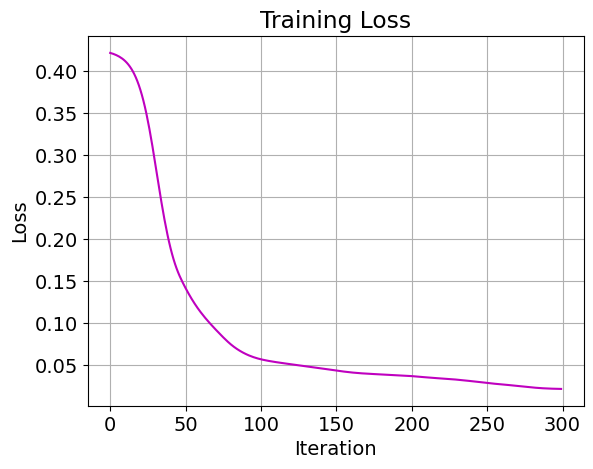

In [133]:
# plot the loss
plt.plot(losses, color='m')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

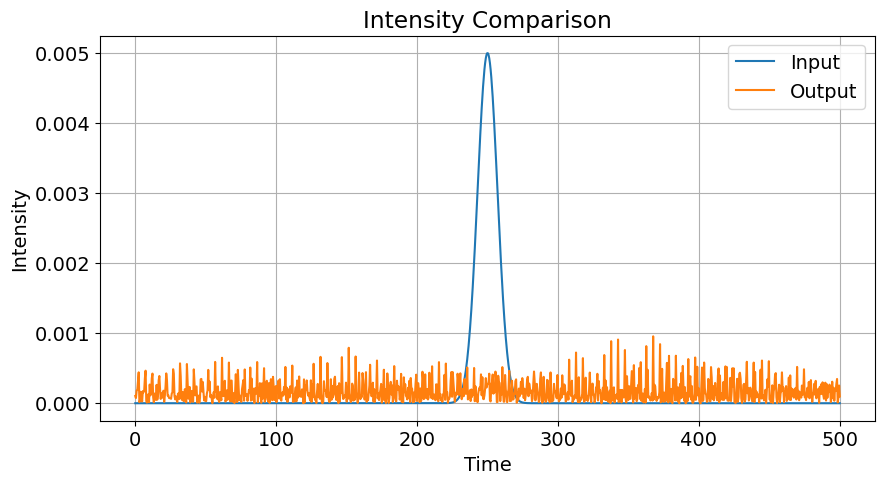

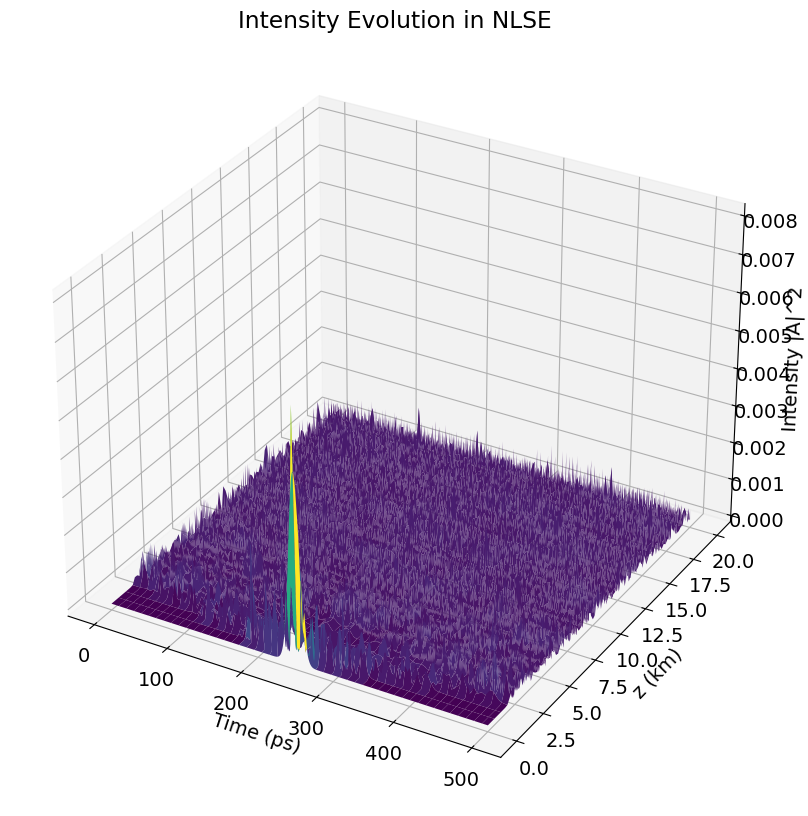

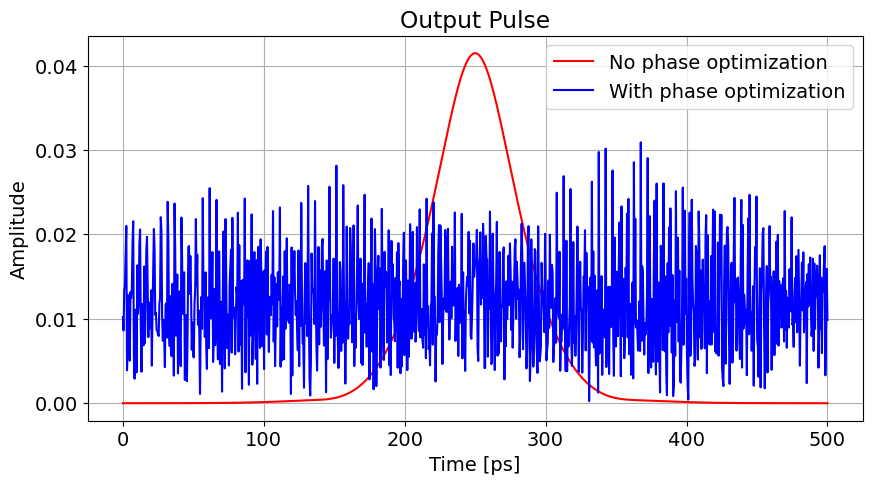

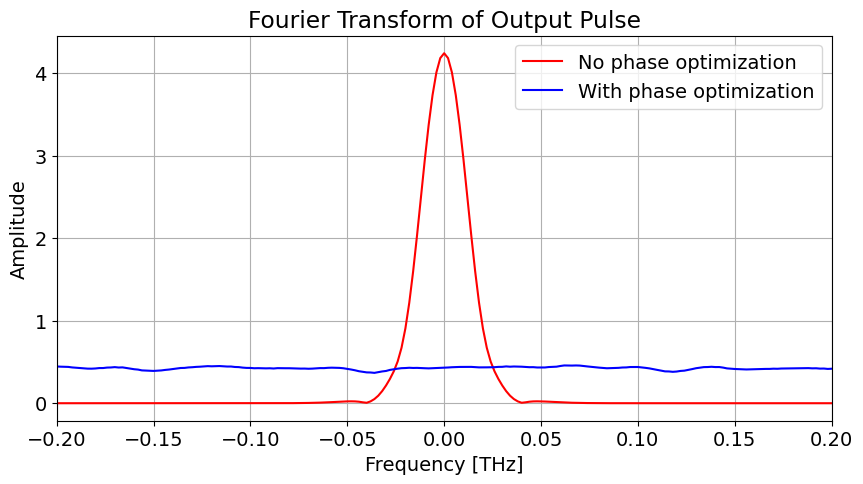

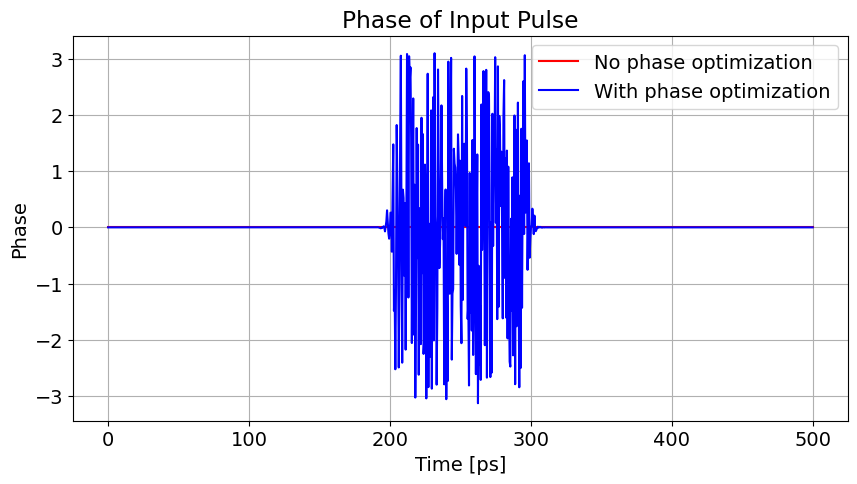

Max Frequency:  0.8460000157356262
SD Loss:  0.42163583636283875 effective loss:  0.42163583636283875
Penalty Loss:  3.259348199660575e-31 effective loss:  3.259348199660575e-11
SD Loss:  0.021679138764739037 effective loss:  0.021679138764739037
Penalty Loss:  1.3264735664042515e-11 effective loss:  1326473566.4042516
Initial Loss:  0.42163583636283875 Final Loss:  0.021679138764739037


In [134]:
Ain = get_pulse(phase)
Aout = Aev[:, -1]
A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)

# make plots
plot_intensity_comparison(Ain, Aout, t)
plot_intensity_evolution(A_evolution, t, Lz, Nz)

Ain0 = A
Ain0_evolution = split_step_fourier(Ain0, dz, Nz, beta2, gamma, Lt)
A0out = Ain0_evolution[:, -1]

# plot output with zero-phased input A0 and optimized input Ain
plt.figure(figsize=(10, 5))
plt.plot(t, torch.abs(A0out).detach().numpy(), color='r', label='No phase optimization')
plt.plot(t, torch.abs(Aout).detach().numpy(), color='b', label='With phase optimization')
plt.xlabel('Time [ps]')
plt.ylabel('Amplitude')
plt.title('Output Pulse')
plt.legend()
plt.grid()
plt.show()

# plot output with zero-phased input A0 and optimized input Ain FFTs
plt.figure(figsize=(10, 5))
plt.plot(freqs, torch.abs(fft(A0out)).detach().numpy(), color='r', label='No phase optimization')
plt.plot(freqs, torch.abs(fft(Aout)).detach().numpy(), color='b', label='With phase optimization')
plt.xlim(-0.2, 0.2)
plt.xlabel('Frequency [THz]')
plt.ylabel('Amplitude')
plt.title('Fourier Transform of Output Pulse')
plt.legend()
plt.grid()
plt.show()

# plot phases of each input pulse
plt.figure(figsize=(10, 5))
plt.plot(t, torch.angle(Ain0).detach().numpy(), color='r', label='No phase optimization')
plt.plot(t, torch.angle(Ain).detach().numpy(), color='b', label='With phase optimization')
plt.xlabel('Time [ps]')
plt.ylabel('Phase')
plt.title('Phase of Input Pulse')
plt.legend()
plt.grid()
plt.show()

# find max frequency of the output pulse
max_freq = freqs[torch.argmax(torch.abs(fft(Aout)))]

print("Max Frequency: ", max_freq.item())

# compare losses between A0 and Ain
A0_loss = loss_function(Ain0_evolution)
A_loss = loss_function(A_evolution)

print("Initial Loss: ", A0_loss.item(), "Final Loss: ", A_loss.item())